In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set(rc={'figure.figsize':(20,20)})
%pylab inline

Populating the interactive namespace from numpy and matplotlib


------
## Read Data

In [7]:
columns = ['survival', 'still_alive', 'age_at_heart_attack', 'pericardial_effusion', 
           'fractional_shortening', 'epss', 'lvdd', 'wall_motion_score', 'wall_motion_index', 
           'mult', 'name', 'group', 'alive_at_1']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/echocardiogram/echocardiogram.data', names = columns)

In [8]:
# Dropping unneccessary columns
df.drop(columns = {'mult', 'name', 'group'}, inplace = True)

In [9]:
df.dtypes

survival                 object
still_alive              object
age_at_heart_attack      object
pericardial_effusion      int64
fractional_shortening    object
epss                     object
lvdd                     object
wall_motion_score        object
wall_motion_index        object
alive_at_1               object
dtype: object

-------
## Data Preparation
### Imputation of NA values

In [10]:
# Convert all non-numeric values into NA for easier conversion
def isnumber(x):
    try:
        float(x)
        return True
    except:
        return False

df = df[df.applymap(isnumber)]

In [11]:
# Investigating null frequency throughout all data fields
df.isnull().sum()

survival                  2
still_alive               1
age_at_heart_attack       6
pericardial_effusion      0
fractional_shortening     8
epss                     15
lvdd                     11
wall_motion_score         4
wall_motion_index         2
alive_at_1               57
dtype: int64

In [12]:
# Remove rows with NA values in survival and still_alive columns as imputation on them does not make sense and they are considered important features to the problem statement
df = df[df['survival'].notnull()]
df = df[df['still_alive'].notnull()]

In [13]:
# Fill numeric columns with its mean values
df[['survival', 'age_at_heart_attack', 'fractional_shortening', 'epss', 
    'lvdd', 'wall_motion_score', 'wall_motion_index']] = df[['survival', 'age_at_heart_attack','fractional_shortening', 'epss', 
                                                             'lvdd', 'wall_motion_score', 'wall_motion_index']].astype('float')

df.fillna(df.mean(), inplace = True)

In [14]:
# Dropping alive_at_1 field as it has the most NA values. We will derive the target variable from survival and still_alive columns instead.
df.drop(columns = {'alive_at_1'}, inplace = True)

In [15]:
df.shape

(130, 9)

In [16]:
#########################

#### Addressing the patients who have not been tracked in 1 year and are alive. They are considered irrelevant data for the study.

In [17]:
# Remove wrongly labelled patients
df1 = df.copy()
df1 = df1[(df1['survival'] >= 12) | (df1['still_alive'] != '1')]
df1['survived'] = np.where(df1['survival'] >= 12, '1', '0')
df1.groupby('survived').count()

,survival,still_alive,age_at_heart_attack,pericardial_effusion,fractional_shortening,epss,lvdd,wall_motion_score,wall_motion_index
survived,,,,,,,,,
0,4,4,4,4,4,4,4,4,4
1,92,92,92,92,92,92,92,92,92


The initial idea to predict who amongst the patients could survive after a year was treated as a classification problem. Unfortunately, the number of patients who do not survive after a year is low, hence contributing to a imbalanced dataset for data training. <br> 

I decided to then perform two models where I have 
- (1) **classification model** to determine survival and death irregardless of survival times where *still_alive* is the response variable and 
- (2) **survival analysis model** to predict the survival times with the added effect of covariates through **Cox Propotional Hazards model**.

-------
## Exploratory Data Analysis

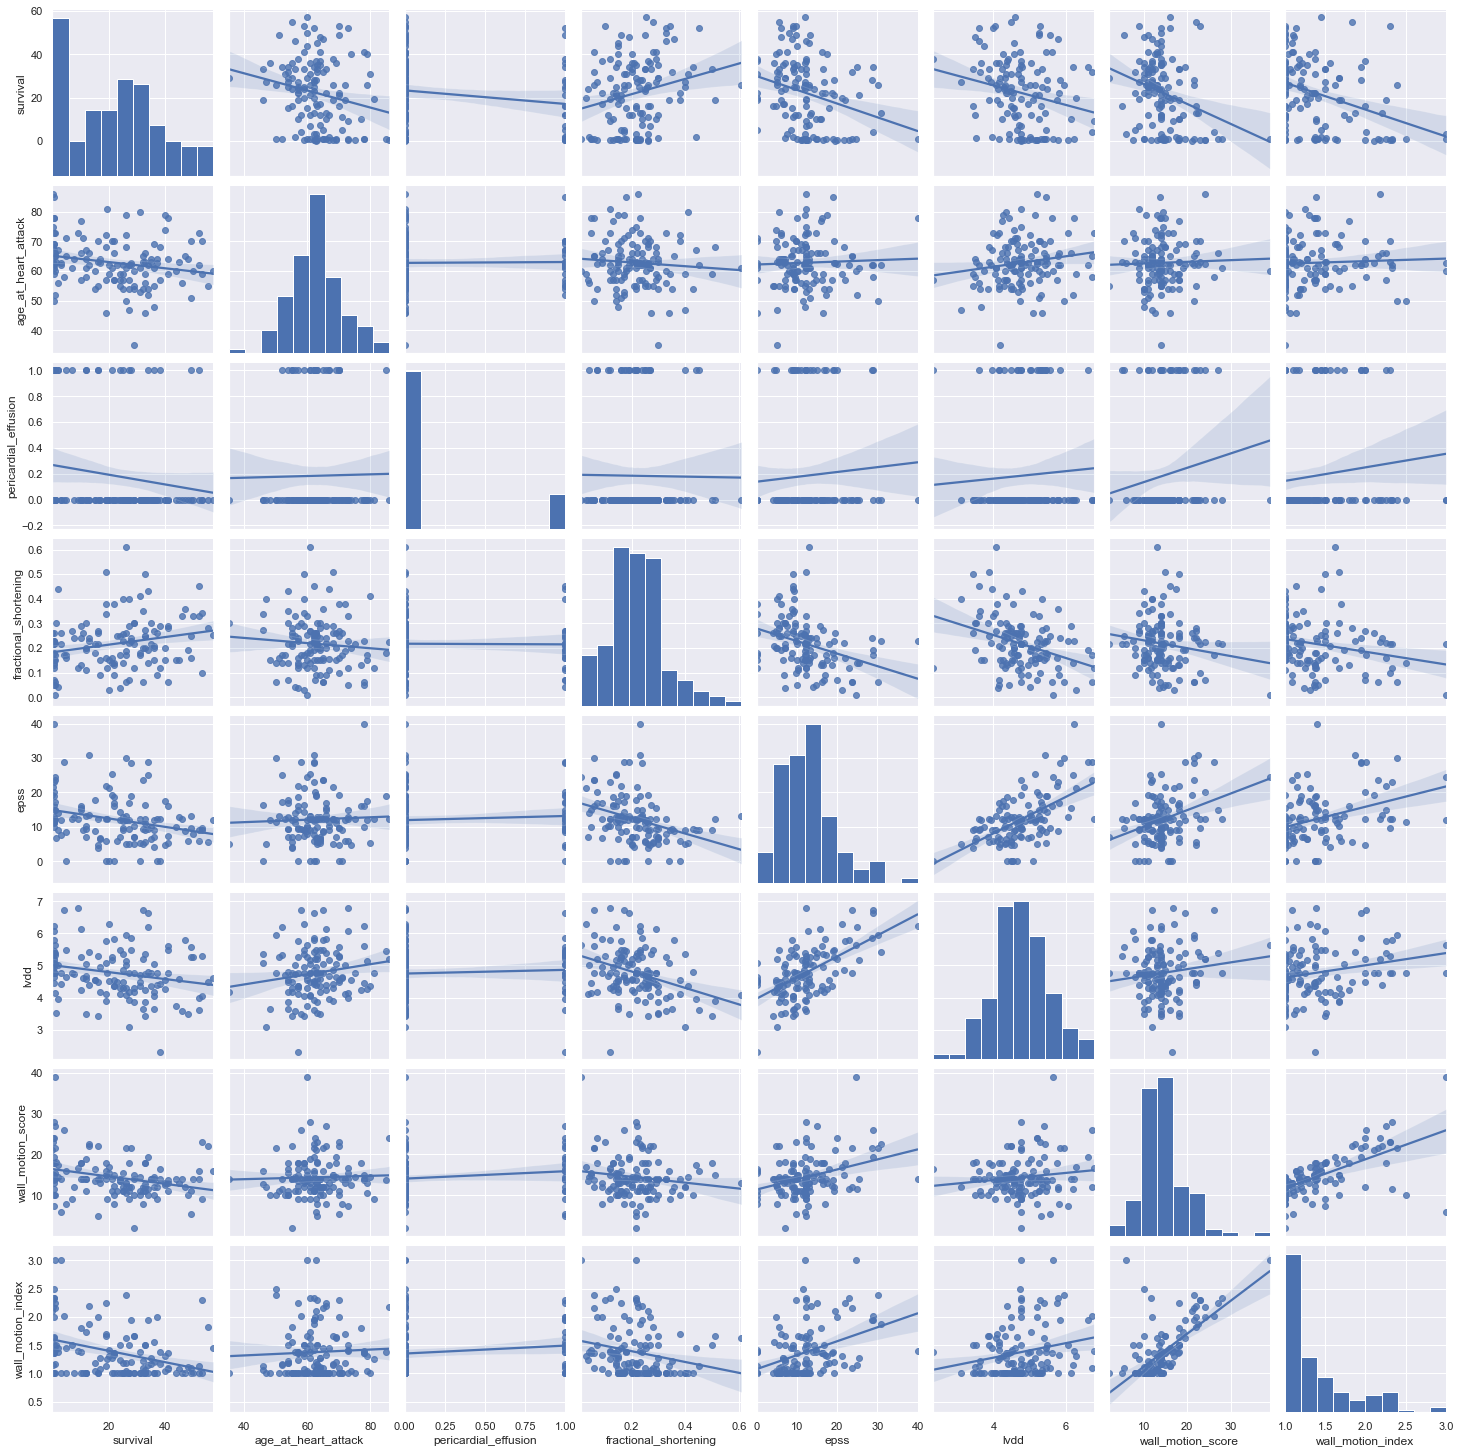

In [18]:
sns.pairplot(df.loc[:, df.columns != 'still_alive'], kind="reg")

Generally, all features are not highly correlated with the survival feature. Hence, they can be used in the study.

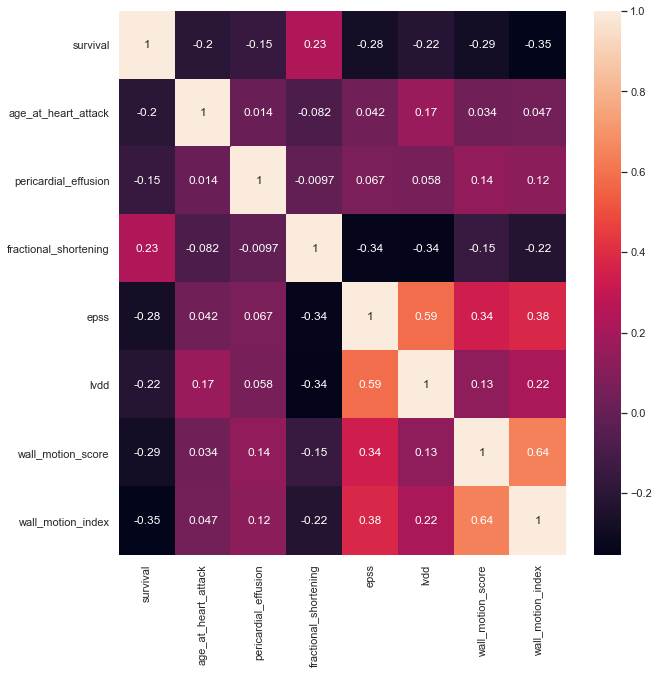

In [19]:
sns.set(rc={'figure.figsize':(10,10)})
corr = df.loc[:, df.columns != 'still_alive'].corr(method='pearson')
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot = True)

----
## Normalisation

In [20]:
from sklearn.preprocessing import StandardScaler

df_norm = df.loc[:, df.columns != 'still_alive']
scaler = StandardScaler()
df_norm.loc[:,:] = scaler.fit_transform(df_norm)

/Users/khalishahnadhirah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


-----
## Train Test Split

In [21]:
X = df_norm.values
y = df['still_alive'].values

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

------
## Classification Model (Random Forest Classifier)

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

I performed a grid search to identify the best parameters to introduce into the random forest classfier.

In [24]:
def rfc_model(X, y):
    # Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestClassifier(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    rfc = RandomForestClassifier(criterion = 'gini', max_depth=best_params['max_depth'], n_estimators=best_params['n_estimators'],random_state=False, verbose=False)
    
    rfc.fit(X,y)
    
    return rfc

In [25]:
rfc = rfc_model(X_train, y_train)

In [30]:
df_norm.head()

,survival,age_at_heart_attack,pericardial_effusion,fractional_shortening,epss,lvdd,wall_motion_score,wall_motion_index
0,-0.708,0.999,-0.476,0.412,-0.458,-0.218,-0.086,-0.839
1,-0.201,1.121,-0.476,1.560,-0.889,-0.863,-0.086,0.716
2,-0.391,-0.957,-0.476,0.412,-1.177,-1.740,-0.086,-0.839
3,2.204,-0.346,-0.476,0.346,-0.018,-0.215,0.317,0.161
4,-0.201,-0.713,-0.476,-0.544,1.410,1.265,0.720,1.938


survival, Importance: 0.47360
age_at_heart_attack, Importance: 0.06853
pericardial_effusion, Importance: 0.01701
fractional_shortening, Importance: 0.08503
epss, Importance: 0.10228
lvdd, Importance: 0.07704
wall_motion_score, Importance: 0.06017
wall_motion_index, Importance: 0.11634


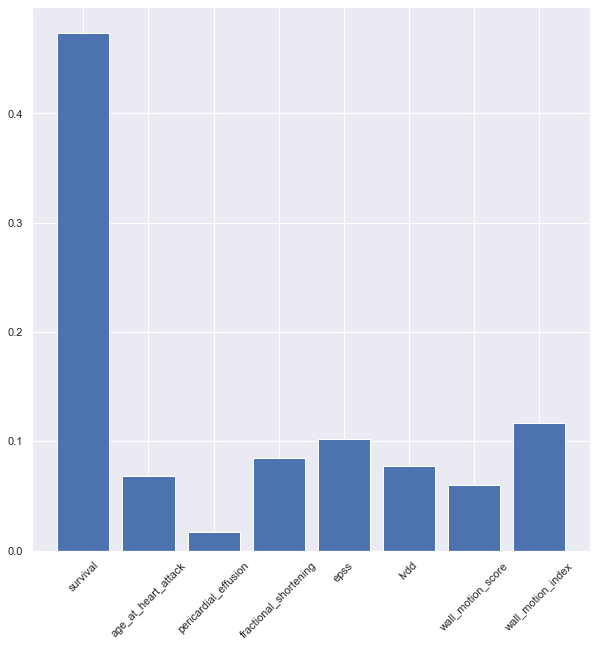

In [37]:
importance = rfc.feature_importances_

for feature,v in zip(df_norm.columns, importance):
    print('%s, Importance: %.5f' % (feature,v))

plt.bar([x for x in df_norm.columns], importance)
plt.xticks(rotation = 45)
plt.show()

The survival feature plays a big importance in the classification model.

In [38]:
## Model Performance
y_pred_train =rfc.predict(X_train)
accuracy = metrics.accuracy_score(y_train, y_pred_train)
print("Accuracy: {:.2f}".format(accuracy))
cm=confusion_matrix(y_train,y_pred_train)
print('Confusion Matrix: \n', cm)
print(classification_report(y_train, y_pred_train))

## Prediction on Test Dataset
y_pred=rfc.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))
cm=confusion_matrix(y_test,y_pred)
print('Confusion Matrix: \n', cm)
print(classification_report(y_test, y_pred))

Accuracy: 0.95
Confusion Matrix: 
 [[69  0]
 [ 5 30]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        69
           1       1.00      0.86      0.92        35

    accuracy                           0.95       104
   macro avg       0.97      0.93      0.94       104
weighted avg       0.96      0.95      0.95       104

Accuracy: 0.88
Confusion Matrix: 
 [[19  0]
 [ 3  4]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.93        19
           1       1.00      0.57      0.73         7

    accuracy                           0.88        26
   macro avg       0.93      0.79      0.83        26
weighted avg       0.90      0.88      0.87        26



The accuracy of the model is very high at 0.95, hence classifying the deaths and survived correctly. We then use this output response variable (still_alive) to determine the death event in the survival analysis.

-----------------

## Survival Analysis

In [39]:
df = df.astype('float64')

Those who are still alive during data collection after a year are considered as censored data as we do not know how long is their survival months after data collection. So *dead* variable is defined as dead at 1 year.

In [40]:
df['dead'] = np.where(df['still_alive'] == 1, 0, 1)

In [41]:
df.groupby('dead').count()

,survival,still_alive,age_at_heart_attack,pericardial_effusion,fractional_shortening,epss,lvdd,wall_motion_score,wall_motion_index
dead,,,,,,,,,
0,42,42,42,42,42,42,42,42,42
1,88,88,88,88,88,88,88,88,88


In [42]:
df.drop(columns = 'still_alive', inplace = True)

## Kaplan Meier Curve

In [43]:
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from scipy import stats
import statistics as stt

In [44]:
kmf = KaplanMeierFitter()
T = df['survival']
E = df['dead']
kmf.fit(T, E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 130 total observations, 42 right-censored observations>

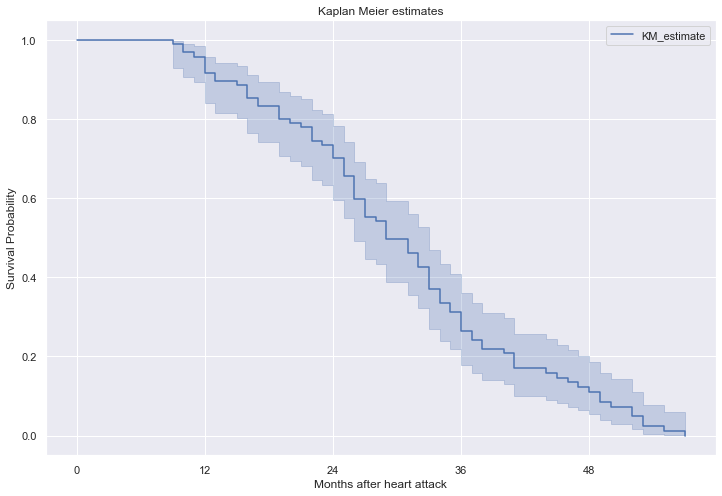

In [45]:
figsize(12,8)
kmf.plot()
plt.title("Kaplan Meier estimates")
plt.xlabel("Months after heart attack")
plt.ylabel("Survival Probability")
plt.xticks(np.arange(0,60,12))
plt.show()

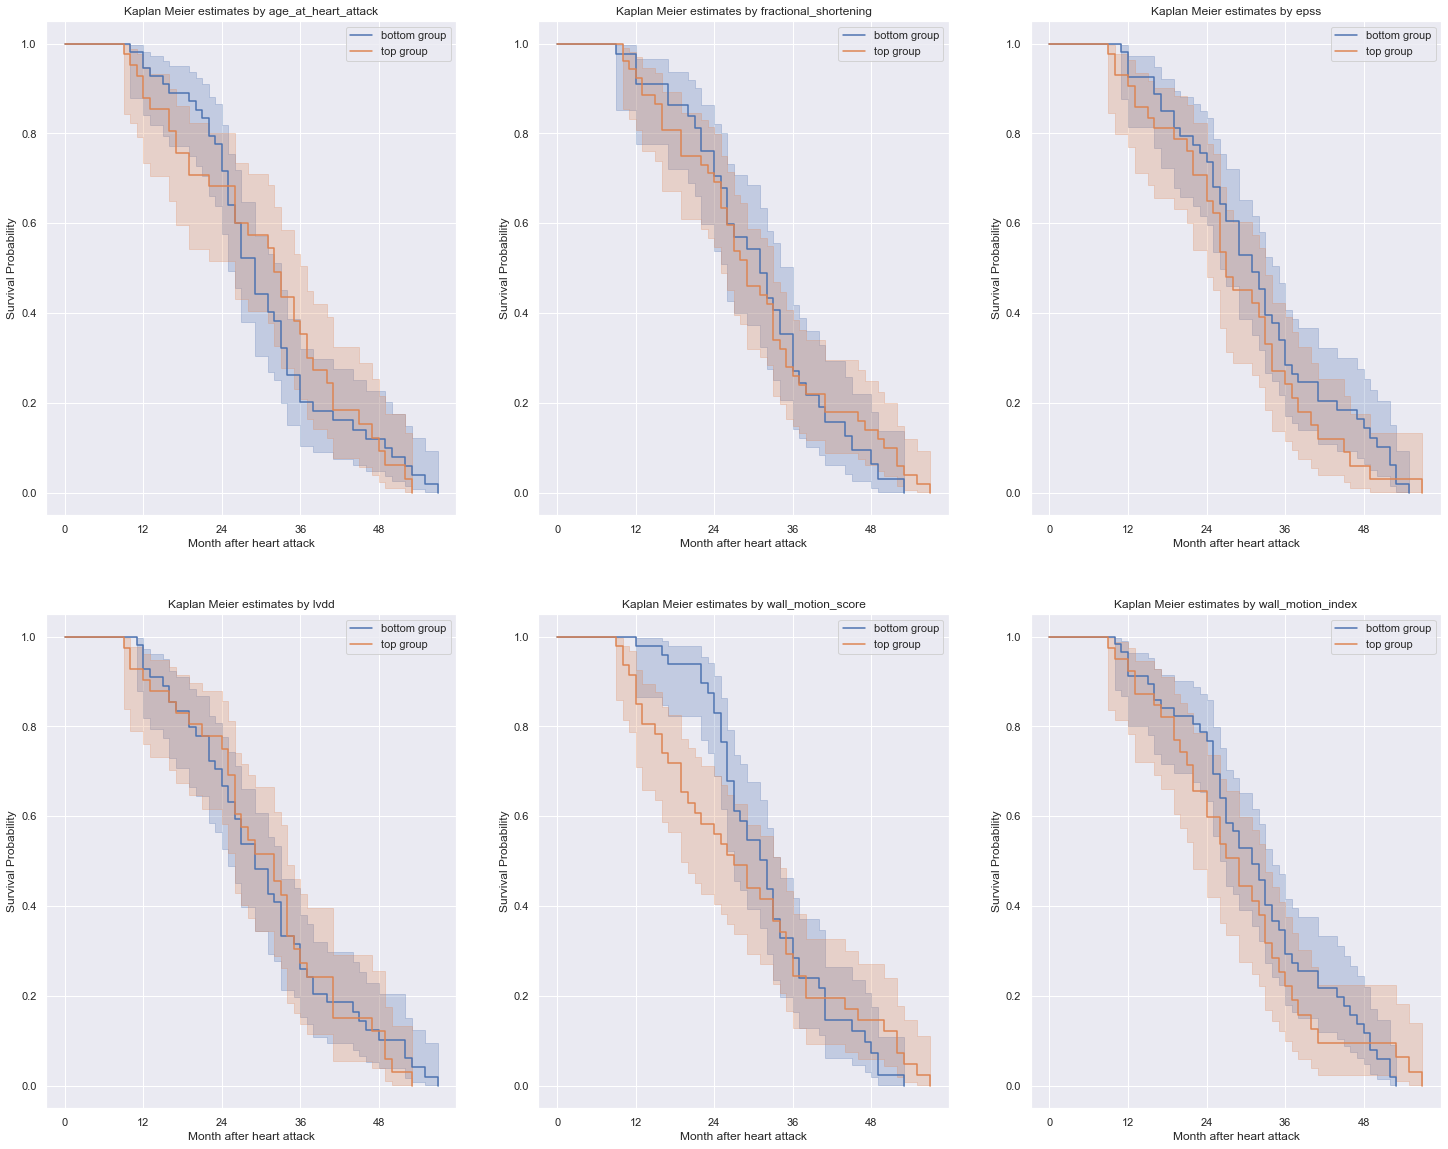

In [46]:
figsize(25,20)
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i, col in zip(range(1, 8), ['age_at_heart_attack', 'fractional_shortening', 'epss', 'lvdd', 'wall_motion_score', 'wall_motion_index']):
    age_group = df[col] < stt.median(df[col])
    ax = fig.add_subplot(2, 3, i)
    kmf.fit(T[age_group], event_observed = E[age_group], label = 'bottom group')
    kmf.plot(ax = ax)
    kmf.fit(T[~age_group], event_observed = E[~age_group], label = 'top group')
    kmf.plot(ax = ax)
    plt.title("Kaplan Meier estimates by %s" % col)
    plt.xlabel("Month after heart attack")
    plt.ylabel("Survival Probability")
    plt.xticks(np.arange(0,60,12))

All features except for wall_motion_score had their survival curves drop before 1 year for every top group of each feature. This means that generally the higher groups in each feature except for wall_motion_score had a lower probablity of surviving death at 1 year.

## Logs Rank Test
I tried to perform a log ranks test for all features individually here. I introduced a new feature *censored* to determine survival behaviour after 1 year of the survival period.

In [47]:
for col in ['age_at_heart_attack', 'fractional_shortening', 'epss', 'lvdd', 'wall_motion_score','wall_motion_index']:
    group_split = df[col] < stt.median(df[col])
    after_2 = 24
    df.loc[(df['dead'] == 1) & (df['survival'] <= after_2), 'censored'] = 1
    df.loc[(df['dead'] == 1) & (df['survival'] > after_2), 'censored'] = 0
    df.loc[df['dead'] == 0, 'censored'] = 0
    E2 = df['censored']

    T_low = T[group_split]
    T_high = T[~group_split]
    E_low = E2[group_split]
    E_high = E2[~group_split]
    print('############')
    print(col)
    print('############')
    results = logrank_test(T_low, T_high, event_observed_A = E_low, event_observed_B = E_high)
    results.print_summary()

############
age_at_heart_attack
############


############
fractional_shortening
############


############
epss
############


############
lvdd
############


############
wall_motion_score
############


############
wall_motion_index
############


While other features are insignificant at the log rank test, the chi square statistic of wall_motion_score of 9.98 is significant as p-value is less than 0.005. There is a significant difference in survival time by wall_motion_score group in the first 2 years of heart attack.

Also, there is great divergence in the survival curve for the wall_motion_score feature between year one and two. We then perform the log rank test to test the null hypothesis of no difference in survival between the higher group of wall_motion_score and its lower group. 

In [61]:
group_split = df['wall_motion_score'] < stt.median(df['wall_motion_score'])
after_2 = 24
df.loc[(df['dead'] == 1) & (df['survival'] <= after_2), 'censored'] = 1
df.loc[(df['dead'] == 1) & (df['survival'] > after_2), 'censored'] = 0
df.loc[df['dead'] == 0, 'censored'] = 0
E2 = df['censored']

T_low = T[group_split]
T_high = T[~group_split]
E_low = E2[group_split]
E_high = E2[~group_split]
results = logrank_test(T_low, T_high, event_observed_A = E_low, event_observed_B = E_high)
results.print_summary()

## Cox Proportional Hazards Model

This is looking at wall_motion_score covariate and its effect to the survival times.

In [62]:
cph = CoxPHFitter()
df_split = pd.DataFrame(group_split)
df_model = df[['survival', 'censored']]
df_model = pd.concat([df_model, df_split], axis = 1)
cph.fit(df_model, 'survival', 'censored')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 130 total observations, 102 right-censored observations>
             duration col = 'survival'
                event col = 'censored'
      baseline estimation = breslow
   number of observations = 130
number of events observed = 28
   partial log-likelihood = -117.74
         time fit was run = 2020-08-25 04:09:30 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
wall_motion_score  -1.24       0.29       0.42            -2.06            -0.42                 0.13                 0.66
                      z      p   -log2(p)
covariate                                
wall_motion_score -2.96 <0.005       8.36
---
Concordance = 0.66
Partial AIC = 237.48
log-likelihood ratio test = 9.91 on 1 df
-log2(p) of ll-ratio test = 9.25

In [63]:
# p-value of Log-likelihood ratio test
round(stats.chi2.sf((9.91), 1),4)

0.0016

From the summary window, we could see that the model containing the wall_motion_score covariate is significant with a chi-square statistic at 1 degree of freedom with p-value of 0.0016 (less than 0.005). Patients with low wall_motion_score reduces the risk of death. For the two years after each patient experiences heart attack, the people with high wall_motion_score would have a higher risk of death.

In [64]:
for col in ['age_at_heart_attack', 'fractional_shortening', 'epss', 'lvdd', 'pericardial_effusion','wall_motion_index']:
    cph = CoxPHFitter()
    df_split = pd.DataFrame(group_split)
    df_model = df[['survival', 'censored', col]]
    df_model = pd.concat([df_model, df_split], axis = 1)
    cph.fit(df_model, 'survival', 'censored')
    cph.print_summary()

<lifelines.CoxPHFitter: fitted with 130 total observations, 102 right-censored observations>
             duration col = 'survival'
                event col = 'censored'
      baseline estimation = breslow
   number of observations = 130
number of events observed = 28
   partial log-likelihood = -117.35
         time fit was run = 2020-08-25 04:09:36 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
age_at_heart_attack   0.02       1.02       0.02            -0.03             0.07                 0.97                 1.07
wall_motion_score    -1.27       0.28       0.42            -2.09            -0.45                 0.12                 0.64
                        z      p   -log2(p)
covariate                                  
age_at_heart_attack  0.88   0.38       1.39
wall_motion_score   -3.02 <0.005       8.63
---
Concordance = 0.70
Partial AIC = 238.71
log-likelihood ratio test = 10.68 on 2 df
-log2(p) of ll-ratio test = 7.71

<lifelines.CoxPHFitter: fitted with 130 total observations, 102 right-censored observations>
             duration col = 'survival'
                event col = 'censored'
      baseline estimation = breslow
   number of observations = 130
number of events observed = 28
   partial log-likelihood = -117.57
         time fit was run = 2020-08-25 04:09:36 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
fractional_shortening  -1.00       0.37       1.74            -4.41             2.41                 0.01                11.19
wall_motion_score      -1.25       0.29       0.42            -2.07            -0.43                 0.13                 0.65
                          z      p   -log2(p)
covariate                                    
fractional_shortening -0.57   0.57       0.82
wall_motion_score     -2.98 <0.005       8.45
---
Concordance = 0.68
Partial AIC = 239.15
log-likelihood ratio test = 10.25 on 2 df
-log2(p) of ll-ratio test = 7.39

<lifelines.CoxPHFitter: fitted with 130 total observations, 102 right-censored observations>
             duration col = 'survival'
                event col = 'censored'
      baseline estimation = breslow
   number of observations = 130
number of events observed = 28
   partial log-likelihood = -117.72
         time fit was run = 2020-08-25 04:09:36 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
epss               -0.01       0.99       0.03            -0.06             0.05                 0.94                 1.05
wall_motion_score  -1.25       0.29       0.42            -2.07            -0.42                 0.13                 0.65
                      z      p   -log2(p)
covariate                                
epss              -0.22   0.83       0.27
wall_motion_score -2.97 <0.005       8.39
---
Concordance = 0.66
Partial AIC = 239.43
log-likelihood ratio test = 9.96 on 2 df
-log2(p) of ll-ratio test = 7.18

<lifelines.CoxPHFitter: fitted with 130 total observations, 102 right-censored observations>
             duration col = 'survival'
                event col = 'censored'
      baseline estimation = breslow
   number of observations = 130
number of events observed = 28
   partial log-likelihood = -117.43
         time fit was run = 2020-08-25 04:09:37 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
lvdd                0.18       1.19       0.22            -0.26             0.62                 0.77                 1.85
wall_motion_score  -1.28       0.28       0.42            -2.11            -0.45                 0.12                 0.64
                      z      p   -log2(p)
covariate                                
lvdd               0.79   0.43       1.23
wall_motion_score -3.04 <0.005       8.71
---
Concordance = 0.69
Partial AIC = 238.86
log-likelihood ratio test = 10.53 on 2 df
-log2(p) of ll-ratio test = 7.60

<lifelines.CoxPHFitter: fitted with 130 total observations, 102 right-censored observations>
             duration col = 'survival'
                event col = 'censored'
      baseline estimation = breslow
   number of observations = 130
number of events observed = 28
   partial log-likelihood = -117.74
         time fit was run = 2020-08-25 04:09:37 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
pericardial_effusion  -0.03       0.97       0.50            -1.02             0.95                 0.36                 2.59
wall_motion_score     -1.25       0.29       0.43            -2.08            -0.41                 0.12                 0.66
                         z      p   -log2(p)
covariate                                   
pericardial_effusion -0.06   0.95       0.07
wall_motion_score    -2.92 <0.005       8.18
---
Concordance = 0.66
Partial AIC = 239.48
log-likelihood ratio test = 9.91 on 2 df
-log2(p) of ll-ratio test = 7.15

<lifelines.CoxPHFitter: fitted with 130 total observations, 102 right-censored observations>
             duration col = 'survival'
                event col = 'censored'
      baseline estimation = breslow
   number of observations = 130
number of events observed = 28
   partial log-likelihood = -117.64
         time fit was run = 2020-08-25 04:09:37 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
wall_motion_index  -0.25       0.78       0.56            -1.34             0.84                 0.26                 2.32
wall_motion_score  -1.31       0.27       0.44            -2.18            -0.44                 0.11                 0.64
                      z      p   -log2(p)
covariate                                
wall_motion_index -0.45   0.66       0.61
wall_motion_score -2.95 <0.005       8.31
---
Concordance = 0.67
Partial AIC = 239.27
log-likelihood ratio test = 10.12 on 2 df
-log2(p) of ll-ratio test = 7.30

When an additional covariate is added on top of wall_motion_score, the model with *age_at_heart_attack* has the highest log-likelihood test and hence, has a better goodness of fit. However, *age_at_heart_attack* variable has less significance to the model with p-value of 0.38 (more than 0.05).

In [76]:
cph = CoxPHFitter()
df_split = pd.DataFrame(group_split)
df_model = df[['survival', 'censored', 'age_at_heart_attack']]
df_model = pd.concat([df_model, df_split], axis = 1)
cph.fit(df_model, 'survival', 'censored')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 130 total observations, 102 right-censored observations>
             duration col = 'survival'
                event col = 'censored'
      baseline estimation = breslow
   number of observations = 130
number of events observed = 28
   partial log-likelihood = -117.35
         time fit was run = 2020-08-25 04:51:57 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
age_at_heart_attack   0.02       1.02       0.02            -0.03             0.07                 0.97                 1.07
wall_motion_score    -1.27       0.28       0.42            -2.09            -0.45                 0.12                 0.64
                        z      p   -log2(p)
covariate                                  
age_at_heart_attack  0.88   0.38       1.39
wall_motion_score   -3.02 <0.005       8.63
---
Concordance = 0.70
Partial AIC = 238.71
log-likelihood ratio test = 10.68 on 2 df
-log2(p) of ll-ratio test = 7.71

In [56]:
# p-value of Log-likelihood ratio test
round(stats.chi2.sf(10.68, 2),4)

0.0048

From the summary window, we could see that the model containing both the wall_motion_score and age_at_heart_attack covariates is significant with a chi-square statistic at 2 degree of freedoms with p-value of 0.0048 (less than 0.005). Since the coefficients of a Cox regression leads to hazard, then the negative sign of wall_motion_score means that the patients with low wall_motion_score has a good chance of survival. For the 2 years after each patient experiences heart attack, the people with high wall_motion_score would have a higher risk of death.

## Appendix (Old Investigations)

In [292]:
def train_model(model, X_train, Y_train):
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error
    
    ## Fit the model
    model.fit(X_train, Y_train)
    try:
        print(model.best_params_)
        print(model.best_score_)
    except:
        print("No available best parameters for this model")
    
    ## Plot the prediction for the train set
    Y_pred = model.predict(X_train)
    plot = plt.scatter(Y_train, Y_pred)
    
    # Plot line of best fit
    m, b = np.polyfit(Y_train, Y_pred, 1)
    plt.plot(Y_train, m*Y_train + b)
     
    plt.xlabel("True Survival Duration")                          
    plt.ylabel("Predicted Survival Duration")

def test_predictions(model, X_test, Y_test):
    import matplotlib.pyplot as plt
    
    Y_pred = model.predict(X_test)
    plt.scatter(Y_test, Y_pred)
    plt.xlabel("True Survival Duration")                          
    plt.ylabel("Predicted Survival Duration")
    
    print(((Y_pred - Y_test)**2).sum() / len(Y_pred))
    return Y_pred

def mse(model, X_test, Y_test):
    from sklearn.metrics import mean_squared_error
    Y_pred = model.predict(X_test)
    
    return mean_squared_error(Y_test, Y_pred)

In [293]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR, NuSVR
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor

No available best parameters for this model


TypeError: can only concatenate str (not "float") to str

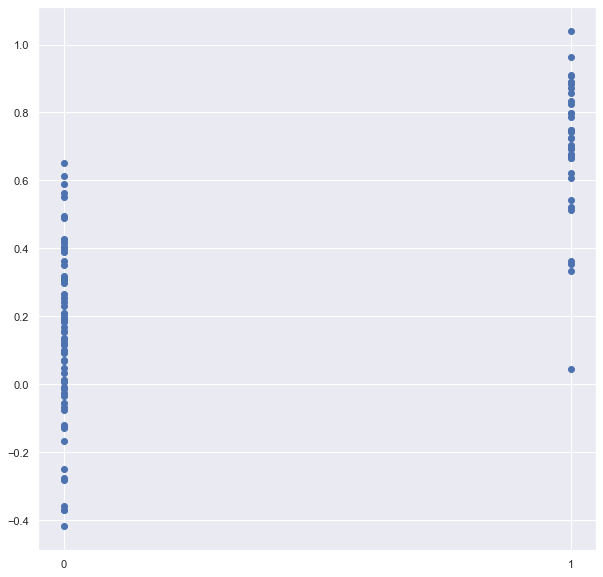

In [294]:
linear = LinearRegression()

train_model(linear, X_train, y_train)

In [ ]:
lasso = GridSearchCV(
                   Lasso(),
                   cv=5,
                   param_grid={
                      "alpha": np.logspace(-3, 3, 1000),
                     }
                   )
train_model(lasso, X_train, y_train)

In [ ]:
ridge = GridSearchCV(
                   Ridge(),
                   cv=5,
                   param_grid={
                      "alpha": np.logspace(-3, 3, 1000),
                     }
                   )
train_model(ridge, X_train, y_train)

In [ ]:
neighbor = GridSearchCV(
                   KNeighborsRegressor(),
                   cv=5,
                   param_grid={
                      "n_neighbors": [5, 10, 25, 40],
                      "weights": ["uniform", "distance"],
                      "algorithm":["ball_tree", "kd_tree", "brute"]
                     }
                   )
train_model(neighbor, X_train, y_train)

In [ ]:
svr = GridSearchCV(
                   SVR(),
                   cv=5,
                   param_grid={
                      "kernel":["rbf"],
                      "C": np.logspace(-3, 6, 20),
                      "gamma": np.logspace(-3, 3, 10),
                      "epsilon": np.logspace(-6, 0, 10)
                     }
                   )
    
train_model(svr, X_train, y_train)

In [ ]:
kridge = GridSearchCV(
                   KernelRidge(),
                   cv=5,
                   param_grid={
                      "alpha": np.logspace(-3, 3, 10),
                      "kernel":["rbf", "linear", "poly"],
                      "gamma": np.logspace(-3, 3, 10),
                      "degree":[1,2,3]
                     }
                   )
train_model(kridge, X_train, y_train)

In [ ]:
from collections import OrderedDict

models = OrderedDict()
models["lr"] = linear
models["lasso"] = lasso
models["ridge"] = ridge
models["kridge"] = kridge
models["svr"] = svr
models["neighbor"] = neighbor

for name, model in models.items():
    print("%s: %s" % (name, mse(model, X_test, y_test)))

In [ ]:
test_predictions(ridge, X_test, y_test)

In [ ]:
# y_pred = test_predictions(kridge, X_test, y_test)
new = []
old = []
for i, j in zip(y_pred, y_test):
    y_pred_scaled = (i*scaler.scale_[0])+scaler.mean_[0]
    y_test_scaled = (j*scaler.scale_[0])+scaler.mean_[0]
    new.append(y_pred_scaled)
    old.append(y_test_scaled)
plt.scatter(old, new)
plt.xlabel("Actual")                          
plt.ylabel("Predicted")